In [5]:
#!pip install pandas_datareader
#!pip install -Uq seaborn

In [6]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as pdr
import seaborn as sns
from statsmodels.tsa.api import acf, graphics, pacf
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

In [7]:
sns.set_style('darkgrid')
pd.plotting.register_matplotlib_converters()

sns.mpl.rc('figure', figsize=(16,6))
sns.mpl.rc('font', size=14)

In [20]:
# this data depicts US housing growth which has not been seasonally adjusted


data = pdr.get_data_fred('HOUSTNSA',"1959-01-01", "2022-06-01")

In [21]:
data.tail()

,HOUSTNSA
DATE,
2022-02-01,126.1
2022-03-01,142.6
2022-04-01,164.3
2022-05-01,140.6
2022-06-01,144.9


In [22]:
housing = data.HOUSTNSA.pct_change().dropna()
housing.tail()

DATE
2022-02-01    0.042149
2022-03-01    0.130849
2022-04-01    0.152174
2022-05-01   -0.144248
2022-06-01    0.030583
Name: HOUSTNSA, dtype: float64

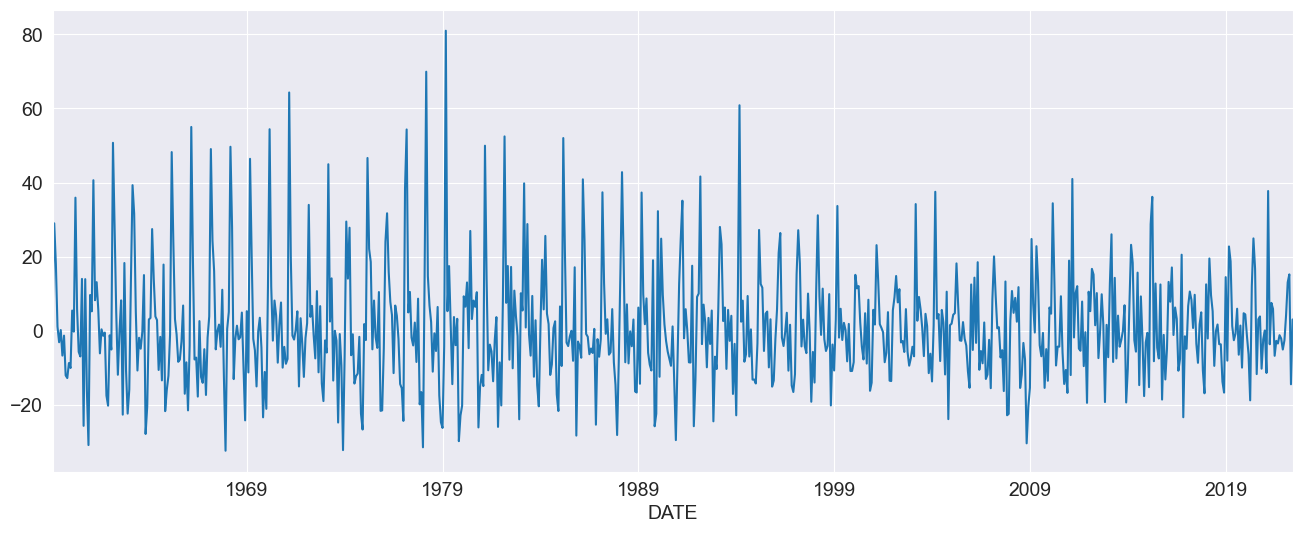

In [23]:
housing = 100*housing.asfreq("MS") #MS means month start
fig, ax = plt.subplots()
ax=housing.plot(ax=ax)

In [24]:
# We can start with an AR(3). Although it is not a good model for this data, it demonstrates the basic use of the API


mod = AutoReg(housing, 3, old_names=False)
res = mod.fit()
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:               HOUSTNSA   No. Observations:                  761
Model:                     AutoReg(3)   Log Likelihood               -3134.297
Method:               Conditional MLE   S.D. of innovations             15.120
Date:                Fri, 03 Nov 2023   AIC                           6278.595
Time:                        21:08:18   BIC                           6301.748
Sample:                    05-01-1959   HQIC                          6287.512
                         - 06-01-2022                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.1378      0.553      2.058      0.040       0.054       2.221
HOUSTNSA.L1     0.1847      0.036      5.184      0.000       0.115       0.255
HOUSTNSA.L2     0.0037      0.036      0.103    

In [25]:
sel = ar_select_order(housing, 13, old_names=False)
sel.ar_lags
res = sel.model.fit()
print(res.summary())


                            AutoReg Model Results                             
Dep. Variable:               HOUSTNSA   No. Observations:                  761
Model:                    AutoReg(13)   Log Likelihood               -2824.445
Method:               Conditional MLE   S.D. of innovations             10.560
Date:                Fri, 03 Nov 2023   AIC                           5678.891
Time:                        21:09:03   BIC                           5748.152
Sample:                    03-01-1960   HQIC                          5705.582
                         - 06-01-2022                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            1.4890      0.459      3.246      0.001       0.590       2.388
HOUSTNSA.L1     -0.2663      0.035     -7.623      0.000      -0.335      -0.198
HOUSTNSA.L2     -0.0881      0.031     -2.82

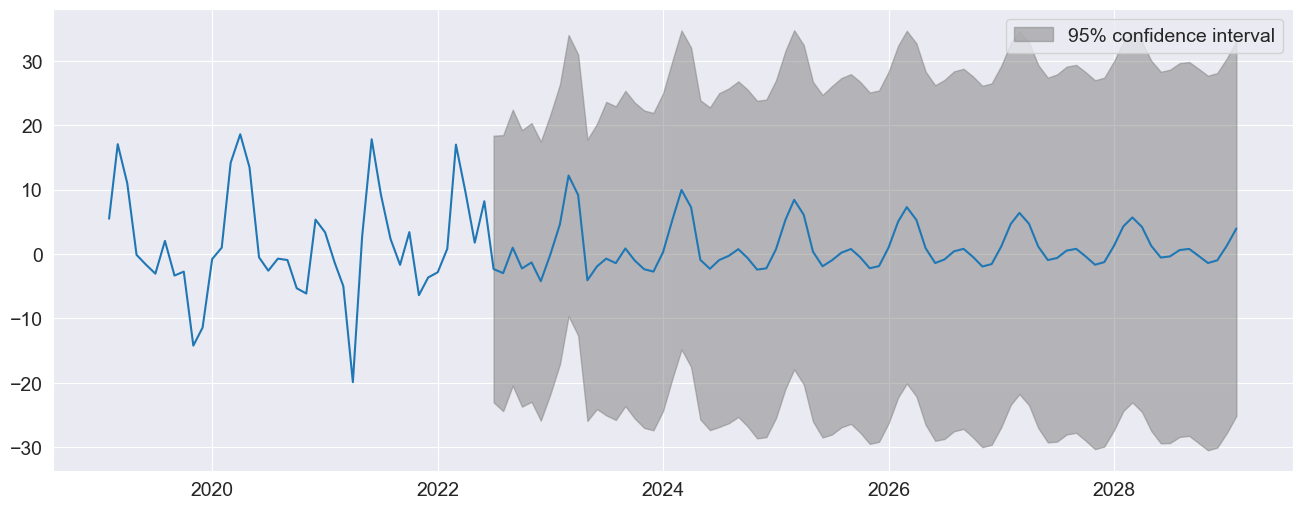

In [26]:
fig = res.plot_predict(720, 840)


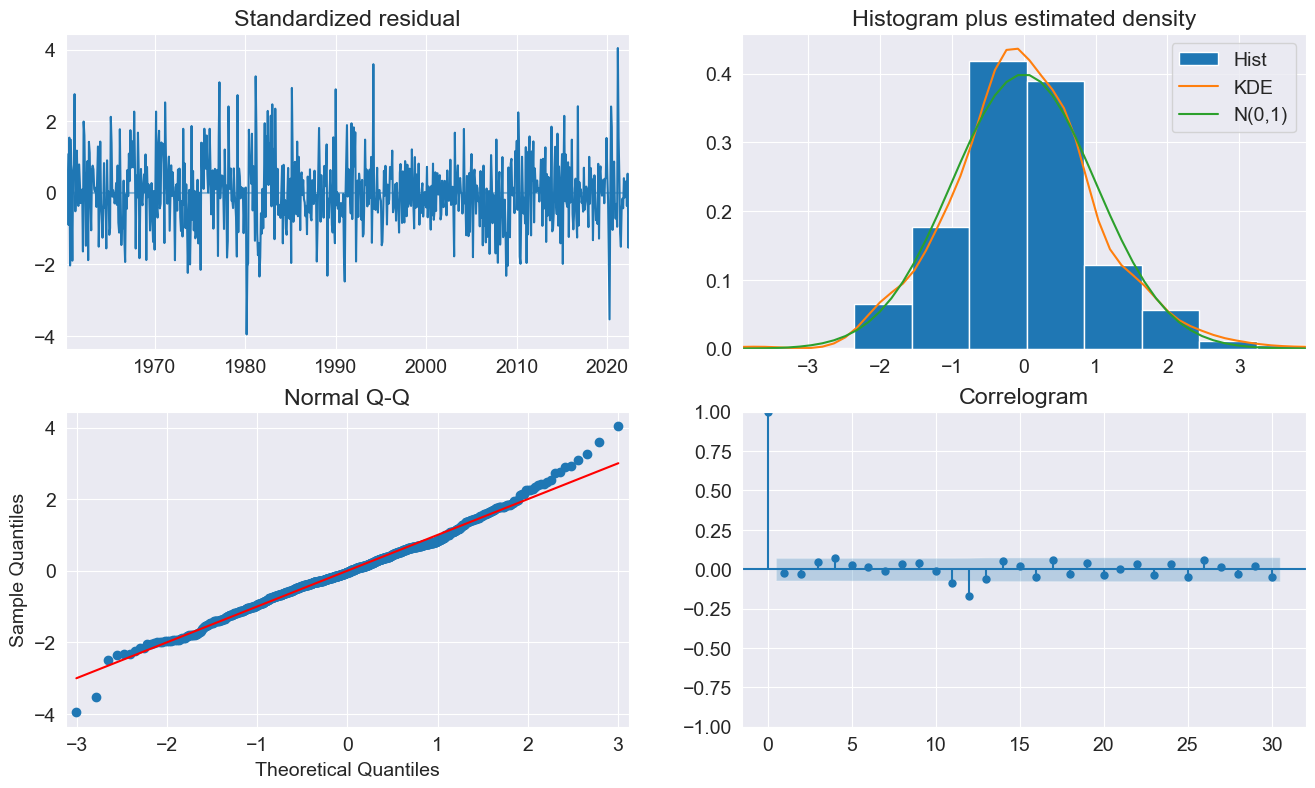

In [27]:
# plot_diagnostics indicates that the model captures the key features in the data

fig = plt.figure(figsize=(16, 9))
fig = res.plot_diagnostics(fig=fig, lags=30)


Seasonal Dummies

In [28]:
sel = ar_select_order(housing, 13, seasonal=True, old_names=False)
sel.ar_lags
res = sel.model.fit()
print(res.summary())


                            AutoReg Model Results                             
Dep. Variable:               HOUSTNSA   No. Observations:                  761
Model:               Seas. AutoReg(2)   Log Likelihood               -2807.996
Method:               Conditional MLE   S.D. of innovations              9.783
Date:                Fri, 03 Nov 2023   AIC                           5645.992
Time:                        21:14:42   BIC                           5715.472
Sample:                    04-01-1959   HQIC                          5672.749
                         - 06-01-2022                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.5072      1.360      1.109      0.268      -1.157       4.172
s(2,12)        31.3226      1.819     17.216      0.000      27.757      34.889
s(3,12)        20.0473      2.360      8.494    

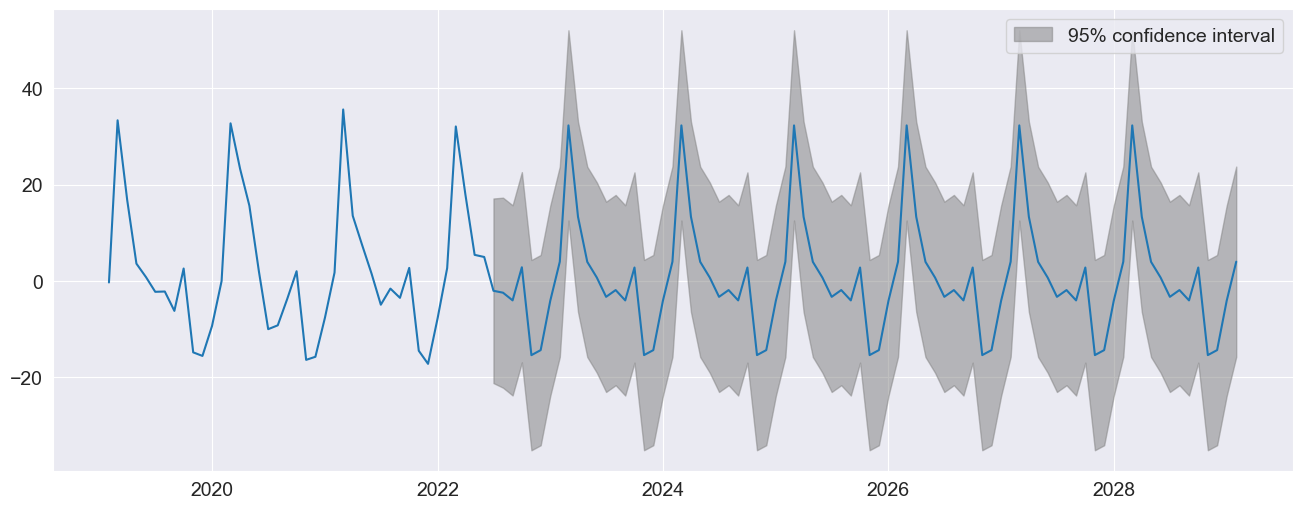

In [29]:
fig = res.plot_predict(720, 840)

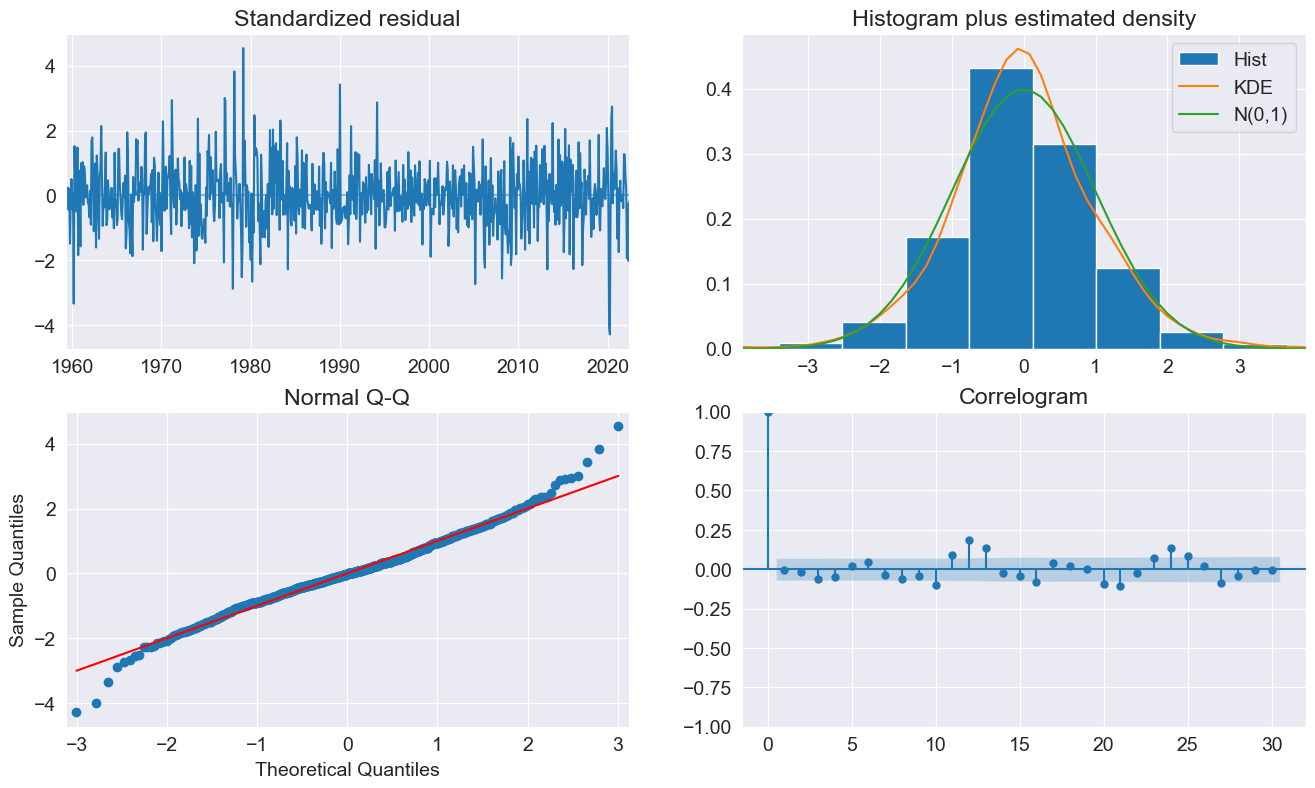

In [30]:
fig  = plt.figure(figsize=(16,9))
fig = res.plot_diagnostics(lags=30, fig=fig)

Seasonal Dynamics

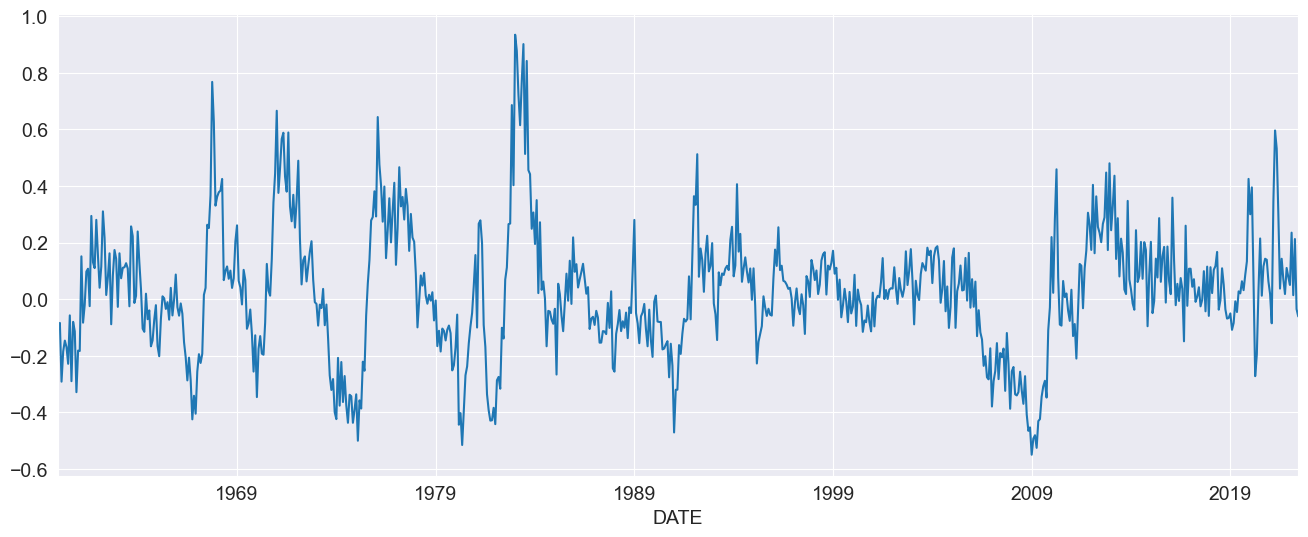

In [31]:
# The autoreg does not directly support seasonal components since it uses OLS to estimate parameters, it is possible to capture seasonal dynamics using an over-parametrized seasonal AR that does not impose the restrictions in the Seasonal AR

yoy_housing = data.HOUSTNSA.pct_change(12).resample("MS").last().dropna()
_, ax = plt.subplots()
ax = yoy_housing.plot(ax=ax)
